In [1]:
import math
import numpy as np
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [12]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor


device="cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [13]:
transform = Compose([ToTensor()])
data_train = CIFAR10(root='.', train=True, download=True, transform=transform)
#data_train = ColoredMNIST(root='.', train=True, download=True, transform=transform)
data_test = CIFAR10(root='.', train=False, download=False, transform=transform)

batch_size=64*2 if torch.cuda.is_available() else 2
train_dataloader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


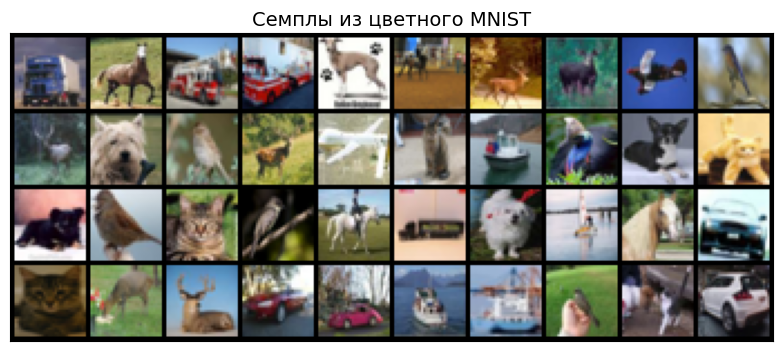

In [14]:
from torchvision.utils import make_grid

def remove_ticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=False,
        labelleft=False
    )

def remove_xticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=True,
        labelleft=True
    )

def visualize_batch(img_vis, title='Семплы из цветного MNIST', nrow=10, ncol=4):
    img_grid = make_grid(img_vis.cpu(), nrow=nrow)
    fig, ax = plt.subplots(1, figsize=(nrow, ncol))
    remove_ticks(ax)
    ax.set_title(title, fontsize=14)
    ax.imshow(img_grid.permute(1, 2, 0))

visualize_batch(next(iter(train_dataloader))[0][:40])

## Loading repo and model

In [15]:
!git clone https://github.com/NVlabs/edm

fatal: destination path 'edm' already exists and is not an empty directory.


In [16]:
!wget https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-ve.pkl

--2024-12-20 14:25:06--  https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-ve.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 3.165.82.11, 3.165.82.67, 3.165.82.69, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|3.165.82.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225848751 (215M) [binary/octet-stream]
Saving to: ‘edm-cifar10-32x32-cond-ve.pkl.1’

edm-cifar10-32x32-c 100%[===================>] 215.39M  82.4MB/s    in 2.6s    

2024-12-20 14:25:10 (82.4 MB/s) - ‘edm-cifar10-32x32-cond-ve.pkl.1’ saved [225848751/225848751]



In [17]:
import sys
sys.path.append('edm')
sys.path.append('edm/training/')
sys.path.append('edm/training/networks')

import pickle
from edm.dnnlib import util
from torch_utils import misc

In [18]:
import dnnlib

def load_net_from_scratch():
    with dnnlib.util.open_url("edm-cifar10-32x32-cond-ve.pkl") as f:
        net = pickle.load(f)['ema'].to(device)

    for i in net.parameters():
        if i.requires_grad:
            print("Yeah!")
    else:
        print("Oh no...")
    # for i in net.parameters():
    #     i.requires_grad=True
    return net
    # return EDMPrecond(net)
net = load_net_from_scratch()

Oh no...


In [19]:
class StackedRandomGenerator:
    def __init__(self, device, seeds=None):
        super().__init__()
        self.generators = [torch.Generator(device).manual_seed(int(seed) % (1 << 32)) for seed in seeds]

    def randn(self, size, **kwargs):
        assert size[0] == len(self.generators)
        return torch.stack([torch.randn(size[1:], generator=gen, **kwargs) for gen in self.generators])

    def randn_like(self, input):
        return self.randn(input.shape, dtype=input.dtype, layout=input.layout, device=input.device)

    def randint(self, *args, size, **kwargs):
        assert size[0] == len(self.generators)
        return torch.stack([torch.randint(*args, size=size[1:], generator=gen, **kwargs) for gen in self.generators])

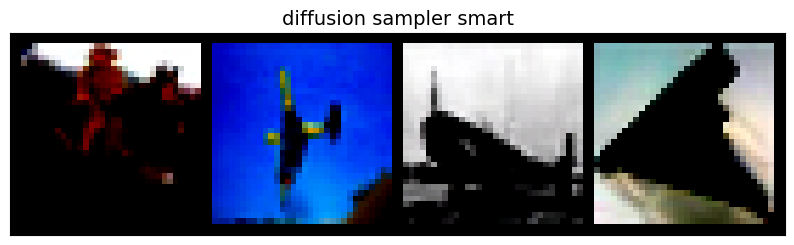

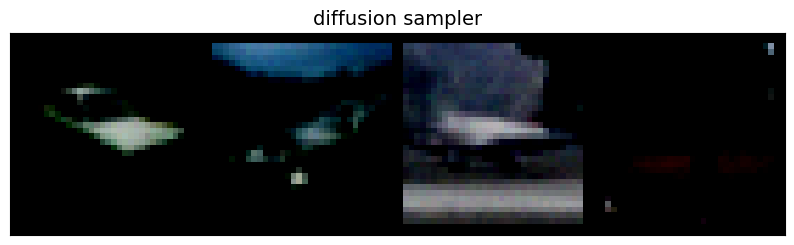

In [20]:
def get_timesteps_diff(num_steps=18):
    sigma_min, sigma_max = 0.002, 80
    rho = 7
    step_indices = torch.arange(num_steps, device=device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    return t_steps

@torch.no_grad()
def consistency_sampler(model, n_pictures_sampling=4, num_steps=5):
    sz = [n_pictures_sampling, 3, 32, 32]

    t = get_timesteps_diff(num_steps=num_steps)

    rnd = StackedRandomGenerator(device=device, seeds=np.random.randint(0, 2 ** 32 - 1, size=sz[0]))
    global latents, labels
    sigma = torch.tensor([80] * 4).to(device)
    imgs = 0
    labels = torch.eye(10, device=device)[rnd.randint(10, size=[sz[0]], device=device)]

    for T in t:
        sigmas = torch.tensor([T] * sz[0]).to(device)
        latents = imgs + rnd.randn(sz, device=device) * sigmas[:, None, None, None]
        denoised = distilled_model(latents, sigmas, labels)
        imgs = denoised

    return denoised

@torch.no_grad()
def diffusion_sampler(
    net, n_pictures_sampling=4,
    num_steps=18,
):

    sz = [n_pictures_sampling, 3, 32, 32]
    rnd = StackedRandomGenerator(device=device, seeds=np.random.randint(0, 2 ** 32 - 1, size=sz[0]))

    latents = rnd.randn(sz, device=device)
    labels = torch.eye(10, device=device)[rnd.randint(10, size=[sz[0]], device=device)]

    # Time step discretization.
    t_steps = get_timesteps_diff(num_steps=num_steps)

    # Main sampling loop.
    x_next = latents.to(torch.float64) * t_steps[0]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily.
        t_hat = net.round_sigma(t_cur)
        x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * rnd.randn_like(x_cur)

        # Euler step.
        denoised = net(x_hat, t_hat, labels).to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur

    return x_next

from generate import edm_sampler
def diffusion_sampler_smart(
    net, n_pictures_sampling=4,
    num_steps=18,
):

    sz = [n_pictures_sampling, 3, 32, 32]
    rnd = StackedRandomGenerator(device=device, seeds=np.random.randint(0, 2 ** 32 - 1, size=sz[0]))

    latents = rnd.randn(sz, device=device)
    labels = torch.eye(10, device=device)[rnd.randint(10, size=[sz[0]], device=device)]
    return edm_sampler(net, latents, labels, num_steps=num_steps)

visualize_batch(diffusion_sampler_smart(net, num_steps=10), "diffusion sampler smart")
plt.show()

visualize_batch(diffusion_sampler(net, num_steps=10), "diffusion sampler")
plt.show()


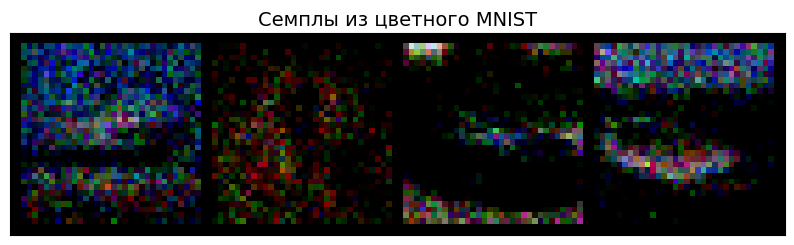

In [21]:
from generate import edm_sampler

# def generate_batch(model, n_pictures_sampling=4, num_steps=18):
#     sz = [n_pictures_sampling, 3, 32, 32]

#     rnd = StackedRandomGenerator(device=device, seeds=np.random.randint(0, 255, size=sz[0]))
#     global latents, labels

#     latents = rnd.randn(sz, device=device)
#     labels = torch.eye(model.label_dim, device=device)[rnd.randint(model.label_dim, size=[sz[0]], device=device)]

#     return edm_sampler(model, latents, labels, num_steps=num_steps)

@torch.no_grad()
def visualize_training(model, loss_history, denoiser_loss_history, one_time_denoised=None, n_pictures=4):
    print(f'''

Iter: {len(loss_history)}
last losses: {loss_history[-5:]}
last denoiser losses: {denoiser_loss_history[-5:]}
''')
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(loss_history)
    axs[1].plot(denoiser_loss_history)
    plt.savefig(f'logs/loss_{len(loss_history)}.png', bbox_inches='tight')
    plt.show()

    visualize_batch(consistency_sampler(model, n_pictures, num_steps=5), title="Consistency sampler, 5 steps")
    plt.savefig(f'logs/consistency_sampler_{len(loss_history)}.png', bbox_inches='tight')
    plt.show()

    visualize_batch(diffusion_sampler(net, n_pictures, num_steps=5), title="Edm sampler, 5 steps")
    plt.savefig(f'logs/edm_sampler_{len(loss_history)}.png', bbox_inches='tight')
    plt.show()

visualize_batch(diffusion_sampler(net, 4, num_steps=4).cpu())

In [22]:
from copy import deepcopy

@torch.no_grad()
def force_exp_average(model_old, model_new, alpha=0.99):
    for p_old, p_new in zip(model_old.parameters(), model_new.parameters()):
        p_old *= alpha
        p_old += p_new.detach() * (1-alpha)
    return model_old

In [23]:
import numpy as np

t = torch.tensor([4, 5, 6])
def sample_adj_pairs(t, cnt):
    indices = torch.randint(0, len(t) - 1 , (cnt,))

    return torch.stack([t[indices], t[indices + 1]])
a, b = sample_adj_pairs(t, 5)
print(a)
print(b)

tensor([4, 5, 5, 5, 5])
tensor([5, 6, 6, 6, 6])


## Losses

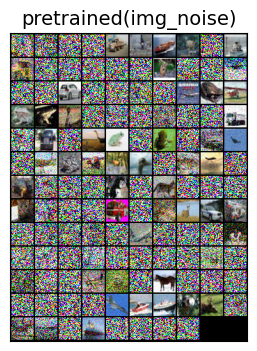

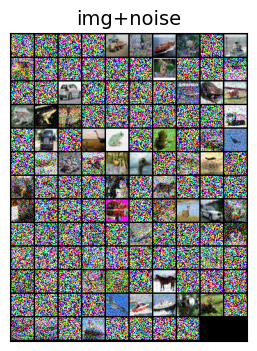

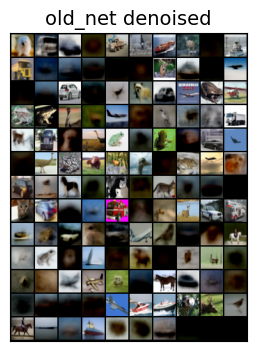

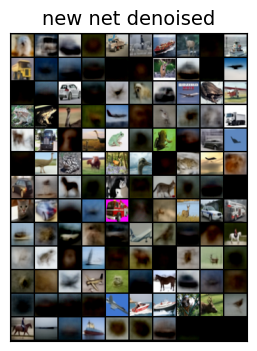

In [24]:
def stat(tens):
    print(tens.min().item(), tens.mean().item(), tens.max().item())

class DistillationLoss:

    def __init__(self, diffusion, sigma_min=0.02, sigma_max=100):
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.diffusion = diffusion
    @torch.no_grad()
    def denoise_batch(self, x_cur, sigma_high, sigma_low, labels):
        denoised = self.diffusion(x_cur, sigma_high, labels).to(torch.float64)
        d_cur = (x_cur - denoised) / sigma_high[:, None, None, None]
        x_next = x_cur - (sigma_high - sigma_low)[:, None, None, None] * d_cur

        return x_next
    def __call__(self, images, images_labels, old_net, net, labels=None):
        labels = torch.eye(10, device=device)[images_labels]

        all_t = get_timesteps_diff().flip(dims=(0,))
        sigma_low, sigma_high = sample_adj_pairs(all_t, images.shape[0])

        weight = 1 / sigma_high[:, None, None, None] ** 2

        y = images
        noise = torch.randn_like(y)
        x_t1 = y + noise * sigma_high[:, None, None, None] # x_{t+1}

        with torch.no_grad():
            x_t = self.denoise_batch(x_t1, sigma_low=sigma_low, sigma_high=sigma_high, labels=labels)
            D_yt = old_net(x_t, sigma_low, labels)

        D_yt1 = net(x_t1, sigma_high, labels)

        loss = weight * ((D_yt1 - D_yt) ** 2)
        with torch.no_grad():
            log_imgs = {
                'clear_images':    images.detach(),
                'noise': noise.detach(),
                'noisy_images':    (x_t.detach(), x_t1.detach()),
                'denoised_images': (D_yt.detach(), D_yt1.detach()),
                'denoiser_err': (D_yt1 - images).square().mean().item(),
                't': sigma_low
            }

        return loss.mean(), log_imgs
# device="cuda:0"
net = net.to(device)
batch, batch_labels = train_dataloader.__iter__().__next__()
loss_fn = DistillationLoss(net)
loss, logs = loss_fn(batch.to(device),batch_labels.to(device), net, net)
visualize_batch(logs['noisy_images'][0].cpu(), title='pretrained(img_noise)')
plt.show()
visualize_batch(logs['noisy_images'][1].cpu(), title='img+noise')
plt.show()
visualize_batch(logs['denoised_images'][0].cpu(), title='old_net denoised')
plt.show()
visualize_batch(logs['denoised_images'][1].cpu(), title='new net denoised')
plt.show()

In [25]:
# visualize_batch(logs['denoised_images'][0].cpu())
# visualize_batch(logs['denoised_images'][1].cpu())

In [26]:
!mkdir checkpoints
!mkdir logs

In [27]:
import os

from IPython.display import clear_output

def train(old_model, model, opt, loss_fn, n_iters, train_loader, update_every=1, eval_every=100, save_every=1000,):
    loss_history = []
    denoiser_loss_history = []

    for param in old_model.parameters():
        param.requires_grad = False
    for param in model.parameters():
        param.requires_grad = True

    model.train()
    opt.zero_grad()
    with tqdm(total=n_iters) as pbar:
        it = 0
        while it < n_iters:
            for batch, batch_labels in train_loader:
                batch = batch.to(device)

                loss, log_imgs = loss_fn(batch, batch_labels, old_model, model)
                loss.backward()
                loss_history.append(loss.item())
                denoiser_loss_history.append(log_imgs['denoiser_err'])

                it += 1

                if it % update_every == 0:
                    opt.step()
                    force_exp_average(old_model, model)
                    opt.zero_grad()

                if it % eval_every == 0:
                    clear_output(wait=True)
                    visualize_training(model, loss_history, denoiser_loss_history,
                        one_time_denoised=log_imgs['denoised_images'][1])

                if it % save_every == 0:
                    torch.save(model.state_dict(), os.path.join('checkpoints', 'rec_%d.pth' %(it,)))
                pbar.update(1)
                pbar.set_description('Loss: %.4g' % loss.item())
                if it == n_iters:
                    break

    return model

In [28]:
torch.autograd.set_detect_anomaly(True)

## Experiments

In [29]:
from tqdm.notebook import tqdm

distilled_model = load_net_from_scratch()
old_model = load_net_from_scratch()

distilled_model.train()
opt = torch.optim.Adam(distilled_model.parameters(), lr=1e-4)

loss_fn = DistillationLoss(net)
# loss_fn = VELoss()
n_iters = 20001

Oh no...
Oh no...


## Train

In [30]:
# !cp "/kaggle/input/diffusion-project-checkpoints/rec_10000 (1).pth" ./checkpoint.pth

In [53]:
# device="cuda:0"; distilled_model.to(device)
if False:
    distilled_model = train(old_model, distilled_model, opt, loss_fn, n_iters, train_dataloader,
                        update_every=1, eval_every=200, save_every=1000)
else:
    checkpoint = torch.load("rec_17000.pth", map_location="cuda:0")
    distilled_model.load_state_dict(checkpoint)

In [33]:
raise ValueError("stop")

ValueError: stop

In [35]:
from torch_utils import distributed as dist
dist.init()

### Small util

In [54]:
import torch
import os
from PIL import Image
import random

def save_subset_to_folder(dataloader, num_samples, folder_path):

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    count = 0
    for out, label in tqdm(dataloader, total=num_samples // batch_size + 1):

        out = (out * 255).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()

        for i in range(out.shape[0]):
            img = Image.fromarray(out[i])
            n_digits = len(str(count))
            img_name = (6 - n_digits) * '0' + str(count) + '.png'
            img.save(os.path.join(folder_path, img_name))
            count += 1
        if count >= num_samples:
            break

In [55]:
import shutil
from tqdm import tqdm

@torch.no_grad()
def consistency_sampler(model, n_pictures_sampling=4, num_steps=5, t=None):
    sz = [n_pictures_sampling, 3, 32, 32]

    if t is None:
        t = get_timesteps_diff(num_steps=num_steps)

    rnd = StackedRandomGenerator(device=device, seeds=np.random.randint(0, 2 ** 32 - 1, size=sz[0]))
    global latents, labels
    sigma = torch.tensor([80] * 4).to(device)
    imgs = 0
    labels = torch.eye(10, device=device)[rnd.randint(10, size=[sz[0]], device=device)]

    for T in t:
        sigmas = torch.tensor([T] * sz[0]).to(device)
        latents = imgs + rnd.randn(sz, device=device) * sigmas[:, None, None, None]
        denoised = distilled_model(latents, sigmas, labels)
        imgs = denoised

    return denoised

# сохраним семплы из модели для дальнейшего подсчета FID у FM модели
def save_model_samples(name, model, sampler, batch_size, num_steps, num_samples, update_every=50, **sampler_kwargs):
    if os.path.exists(name):
        shutil.rmtree(name)

    os.makedirs(name, exist_ok=True)
    count = 0

    with tqdm(total= num_samples) as pbar:
        while count < num_samples:
            cur_batch_size = min(num_samples - count, batch_size)
            out = sampler(model, batch_size, num_steps=num_steps, **sampler_kwargs)

            out = (out * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()

            for i in range(out.shape[0]):
                img = Image.fromarray(out[i])
                n_digits = len(str(count))
                img_name = (6 - n_digits) * '0' + str(count) + '.png'
                img.save(os.path.join(name, img_name))
                count += 1
                if count % update_every == 0:
                    pbar.update(update_every)
                    pbar.set_description('%d images saved' % (count,))

In [56]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

def show_random_images(folder_path, num_images=10, title=''):
    """
    Displays a specified number of random PNG images from a folder.

    Args:
        folder_path: The path to the folder containing the images.
        num_images: The number of images to display.
    """

    png_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.png')]

    if not png_files:
        print(f"No PNG images found in the folder: {folder_path}")
        return

    if num_images > len(png_files):
        print(f"Not enough PNG images found. Displaying {len(png_files)} images.")
        num_images = len(png_files)


    random_files = random.sample(png_files, num_images)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Adjust figsize as needed

    for i, file in enumerate(random_files):
        image_path = os.path.join(folder_path, file)
        try:
            img = mpimg.imread(image_path)
            axes[i].imshow(img)
            axes[i].axis('off')  # Hide axis ticks and labels
            axes[i].set_title(file)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            axes[i].axis('off')
            axes[i].set_title(f"Error loading {file}")

    plt.suptitle(title)
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

### Calculating stats for Cifar10

In [57]:
from fid import calculate_inception_stats, calculate_fid_from_inception_stats

execute=False

if execute:
    max_batch_size=128
    sz = 50000
    save_subset_to_folder(train_dataloader, sz, "CIFAR/")
    mu_base, sigma_base = calculate_inception_stats(image_path="CIFAR/", num_expected=sz, max_batch_size=max_batch_size)

### Evaluating for 1 and 2 steps

In [58]:
execute=False

if execute:
    distilled_model.eval()
    n_samples = 30000
    fid_arr = []
    for i in [1, 2]:
        save_model_samples(f'consistency_samples_{i}', distilled_model, consistency_sampler,
                           update_every=16, batch_size=max_batch_size, num_steps=i, num_samples=n_samples)

        mu_cons, sigma_cons = calculate_inception_stats(image_path=f"consistency_samples_{i}/", num_expected=n_samples, max_batch_size=max_batch_size)
        res = calculate_fid_from_inception_stats(mu_cons, sigma_cons, mu_base, sigma_base)
        print(f"FID for num_samples = {i} ->", res)
        fid_arr.append(res)

### Evaluating for 3 steps

In [59]:
execute=False

if execute:
    custom_t_3 = get_timesteps_diff(18)[[0, 6, 9]]

    i = 3
    save_model_samples(f'consistency_samples_{i}', distilled_model, consistency_sampler,
                           update_every=16, batch_size=max_batch_size, num_steps=i, num_samples=n_samples, t=custom_t_3)

    mu_cons, sigma_cons = calculate_inception_stats(image_path=f"consistency_samples_{i}/", num_expected=n_samples, max_batch_size=max_batch_size)
    res = calculate_fid_from_inception_stats(mu_cons, sigma_cons, mu_base, sigma_base)
    print(f"FID for num_samples = {i} ->", res)


### Show sampling examples

In [60]:
# raise ValueError("Executing this will delete previous samples")

# Saving needed sampels

max_batch_size=128

i = 1
save_model_samples(f'consistency_samples_{i}', distilled_model, consistency_sampler,
                       update_every=16, batch_size=max_batch_size, num_steps=i, num_samples=max_batch_size)

i = 2
save_model_samples(f'consistency_samples_{i}', distilled_model, consistency_sampler,
                       update_every=16, batch_size=max_batch_size, num_steps=i, num_samples=max_batch_size)

custom_t_3 = get_timesteps_diff(18)[[0, 6, 9]]
i = 3
save_model_samples(f'consistency_samples_{i}', distilled_model, consistency_sampler,
                       update_every=16, batch_size=max_batch_size, num_steps=i, num_samples=max_batch_size, t=custom_t_3)

128 images saved: 100%|██████████| 128/128 [00:02<00:00, 46.00it/s]


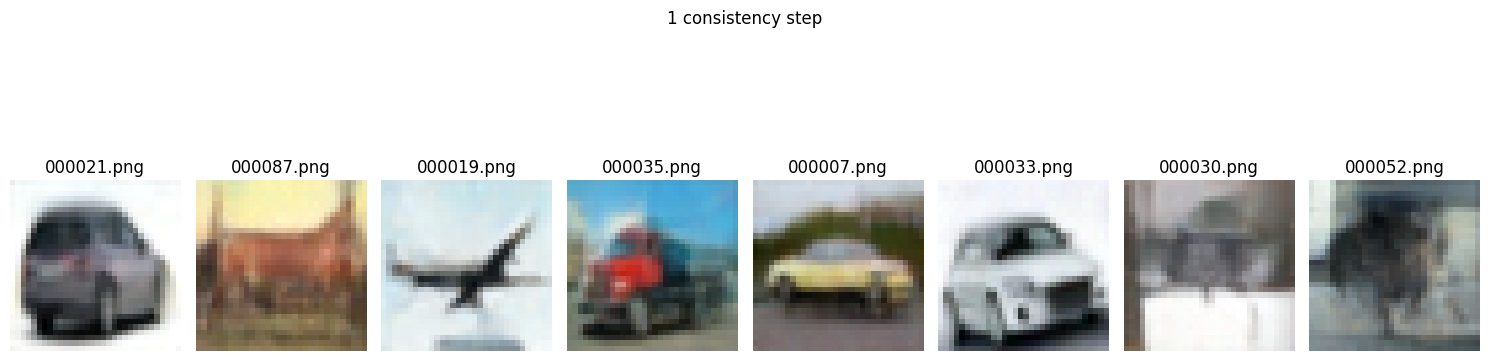

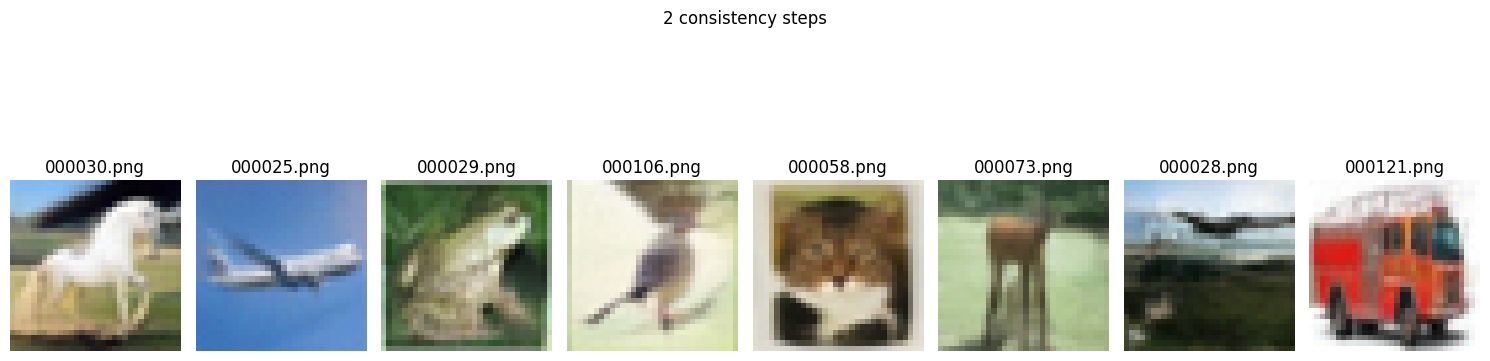

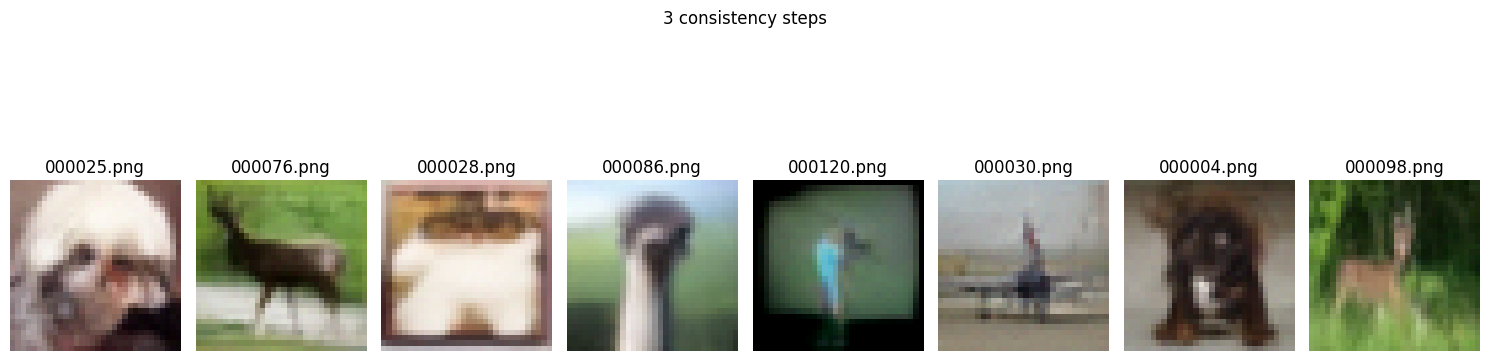

In [61]:
num_images=8

show_random_images("consistency_samples_1", num_images=num_images, title='1 consistency step')
show_random_images("consistency_samples_2", num_images=num_images, title='2 consistency steps')
show_random_images("consistency_samples_3", num_images=num_images, title='3 consistency steps')

### Running with same noise

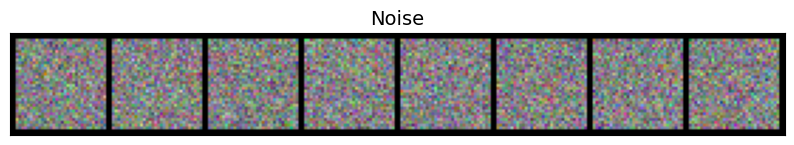

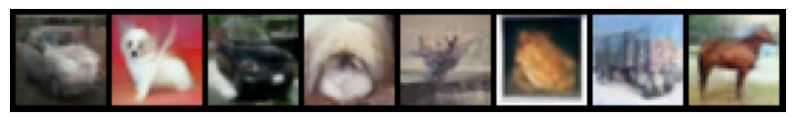

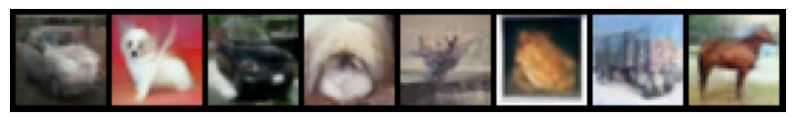

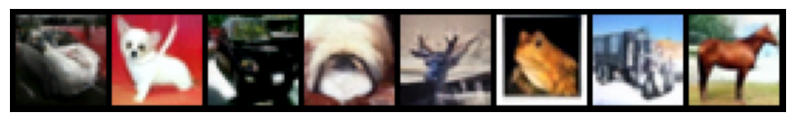

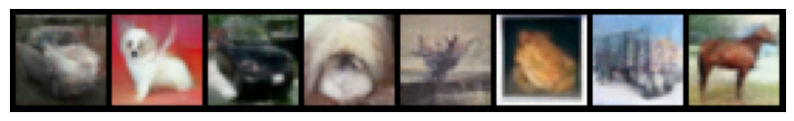

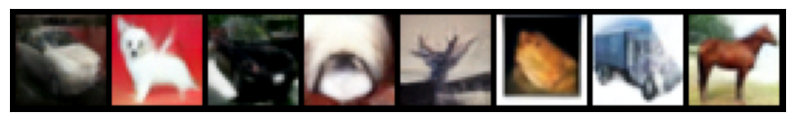

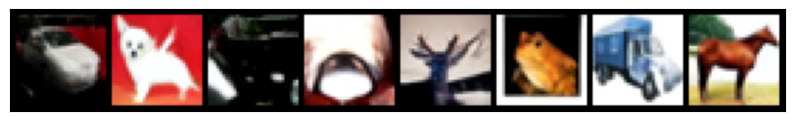

In [64]:
@torch.no_grad()
def consistency_sampler_latent(model, n_pictures_sampling=4, num_steps=5):
    sz = [n_pictures_sampling, 3, 32, 32]

    t = get_timesteps_diff(num_steps=num_steps)

    rnd = StackedRandomGenerator(device=device, seeds=np.random.randint(0, 2 ** 32 - 1, size=sz[0]))
    global latents, labels
    sigma = torch.tensor([80] * 4).to(device)
    imgs = 0
    labels = torch.eye(10, device=device)[rnd.randint(10, size=[sz[0]], device=device)]

    for T in t:
        sigmas = torch.tensor([T] * sz[0]).to(device)
        latents = imgs + rnd.randn(sz, device=device) * sigmas[:, None, None, None]
        denoised = distilled_model(latents, sigmas, labels)
        imgs = denoised

    return denoised

def norm(a):
    return (a - a.min()) / (a.max() - a.min())

batch, labels = train_dataloader.__iter__().__next__()
labels = torch.eye(10, device=device)[labels]
batch = batch.to(device)
n_samples = 8
batch = batch[:8]
labels = labels[:8]

torch.manual_seed(1337)
noise = torch.randn_like(batch, device=device)

# just noise
visualize_batch(norm(noise * 80), "Noise")
plt.show()
print()
print()
print()

# consistency with 1 steps

sigma = torch.tensor([80] * 8, device=device)
cons = distilled_model(noise * 80, sigma, labels)
visualize_batch((cons.clip(-1, 1) + 1) / 2, "")

#consistenmcy with 2 steps

plt.show()
print()
print()
print()
cons = 0
for t in [80, 2.5]:

    sigma = torch.tensor([t] * 8, device=device)
    cons = distilled_model(cons + noise * t, sigma, labels)
    visualize_batch((cons.clip(-1, 1) + 1) / 2, "")
plt.show()
print()
print()
print()
cons = 0
for t in get_timesteps_diff(18)[[0, 6, 9]]:

    sigma = torch.tensor([t] * 8, device=device)
    cons = distilled_model(cons + noise * t, sigma, labels)
    visualize_batch((cons.clip(-1, 1) + 1) / 2, "")
plt.show()
print()
print()
print()

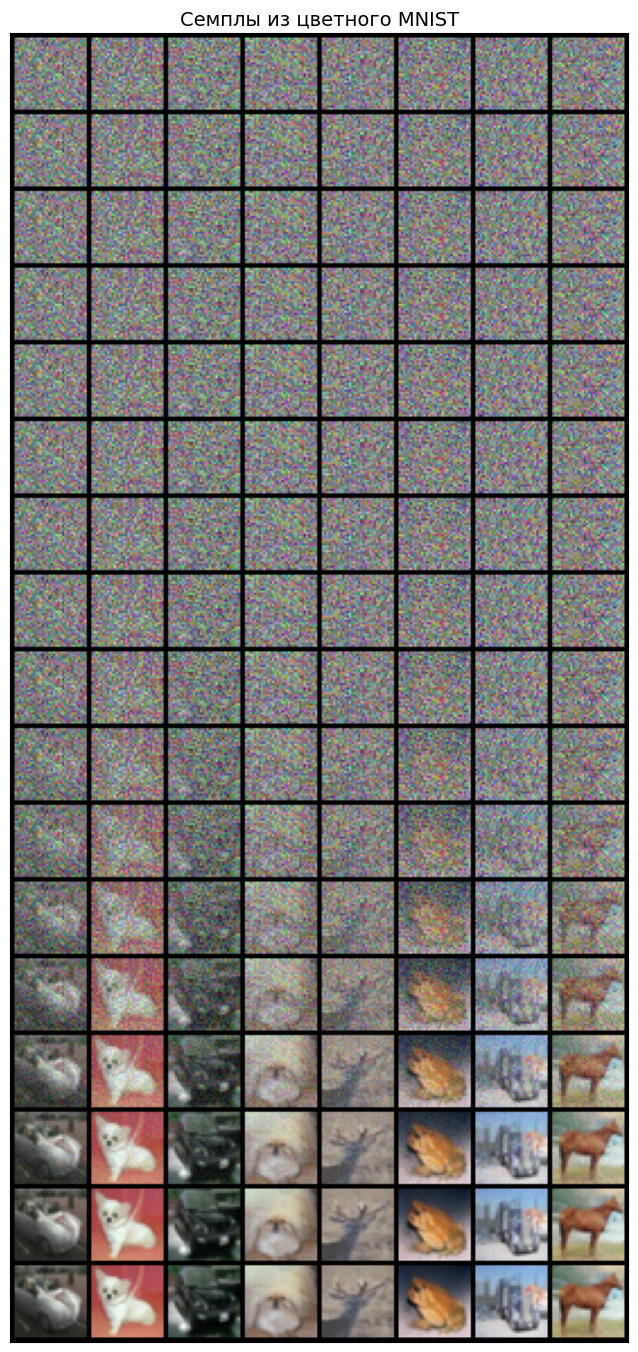

In [65]:

t_steps = get_timesteps_diff(num_steps=18)

x_next = noise.to(torch.float64) * t_steps[0]
history = []
for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
    x_cur = x_next

    # Increase noise temporarily.
    t_hat = t_cur
    x_hat = x_cur

    # Euler step.
    denoised = net(x_hat, t_hat, labels).to(torch.float64)
    d_cur = (x_hat - denoised) / t_hat
    x_next = x_hat + (t_next - t_hat) * d_cur
    history.append(norm(x_next.detach().cpu()))
visualize_batch(torch.cat(history), ncol=len(history), nrow=len(noise))
plt.savefig("edm sampler")